# Imbalance Data

In [90]:
import pandas as pd
import numpy  as np
import seaborn as SB
import matplotlib.pyplot as PLT
import scipy.stats as STATS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn import metrics
import random
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [223]:
n = 5000
skip = sorted(random.sample(range(1,319795),319795-n))
DF = pd.read_csv('../../datasets/heart_2020_cleaned.csv',skiprows=skip).reset_index().rename(columns={'index':'id'})

In [224]:
CatCols = [
    'Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','AgeCategory','Race','Diabetic',
    'PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer'
]
NumCols = [
    'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'
]

X = DF[DF.columns.difference(['id','HeartDisease'])]
Y = DF['HeartDisease']

In [26]:
X.head()

,AgeCategory,AlcoholDrinking,Asthma,BMI,Diabetic,DiffWalking,GenHealth,KidneyDisease,MentalHealth,PhysicalActivity,PhysicalHealth,Race,Sex,SkinCancer,SleepTime,Smoking,Stroke
0,80 or older,No,No,21.63,No,No,Very good,No,0.0,Yes,0.0,Black,Female,No,9.0,Yes,No
1,80 or older,No,Yes,22.14,No,No,Good,No,0.0,Yes,14.0,Black,Male,No,7.0,No,No
2,60-64,No,No,36.02,Yes,Yes,Fair,No,15.0,No,30.0,Black,Female,No,7.0,No,No
3,70-74,No,No,24.41,Yes,No,Very good,No,0.0,Yes,1.0,White,Male,No,6.0,Yes,No
4,65-69,No,No,31.55,No,No,Good,No,0.0,No,0.0,White,Female,No,10.0,Yes,No


In [225]:
# Drop rows with out of rage BMI
BMI_Out_Of_Range = X[X['BMI']>50]
X = X.drop(BMI_Out_Of_Range.index,errors='ignore')

In [226]:
CatCols = [
    'Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','Race','Diabetic',
    'PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer','AgeCategory'
]
NumCols = [
    'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'
]

In [29]:
# _1 = X[X['AgeCategory']!='80 or older']['AgeCategory'].str.split('-').apply(
#     lambda x : (int(x[0])+int(x[1]))/2
# )
# _2 = X[X['AgeCategory']=='80 or older']['AgeCategory'].str.split(' or ').apply(
#     lambda x : 80
# )
# X.loc[_1.index,'AgeCategory'] = _1
# X.loc[_2.index,'AgeCategory'] = _2
# del _1,_2

In [30]:
# X['AgeCategory'] = X['AgeCategory'].astype(np.int64) 

In [31]:
# CatCols = [
#     'Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','Race','Diabetic',
#     'PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer'
# ]
# NumCols = [
#     'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime','AgeCategory'
# ]

In [227]:
X = X.drop(X[X['SleepTime']>16]['SleepTime'].index,axis=0)

# <font color="Green">One Hot Encode Categorical Label :</font>

In [151]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def OHC_transformer_single_column(DF,columns):
    
    for column_name in columns:
        label_encoder = LabelEncoder()
        encoded = label_encoder.fit_transform(DF[column_name])
        labels =pd.Series(label_encoder.classes_)

        clmt = ColumnTransformer([(column_name,OneHotEncoder(),[0])], remainder='passthrough')
        clmt_fited_data = clmt.fit_transform(DF[[column_name]]) 
        clmt_fited_data = clmt_fited_data if type(clmt_fited_data)== np.ndarray else clmt_fited_data.toarray()  
        NDF = pd.DataFrame(clmt_fited_data,columns=[f'{column_name}_{x}' for x in labels])
        
        merged = DF.merge(NDF, left_index=True,right_index=True)
        merged = merged.drop(columns=[column_name])
        DF = merged
    return DF

In [228]:
X_OHC = OHC_transformer_single_column(X,CatCols) 
Y = DF.iloc[X_OHC.index]['HeartDisease']
Y_label_encoder = LabelEncoder()
Y_OHC = Y_label_encoder.fit_transform(Y)

In [229]:
NDF = pd.concat([X,Y],axis=1)
NDF_OHC = pd.concat([X_OHC,pd.DataFrame(Y_OHC,columns=['HeartDisease'])],axis=1)

 # <font color="Green">Normalize  :</font>

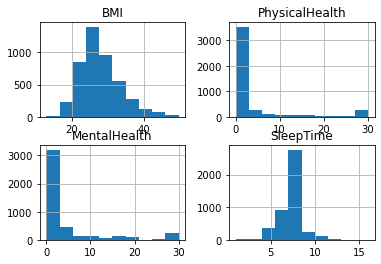

In [192]:
X_OHC[NumCols].hist()
PLT.show()

In [230]:
X_OHC_Norm = X_OHC.copy()
ss = StandardScaler()
X_OHC_Norm[NumCols] = ss.fit_transform(X_OHC[NumCols])

In [231]:
X_OHC_Norm.shape

(4320, 50)

# <font color="Green">Imbalance Data  :</font>

In [232]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

In [213]:
# smote = SMOTE(random_state=3020)
# X_imb, Y_imb = smote.fit_resample(X_OHC_Norm,pd.DataFrame(Y_OHC,columns=['HeartDisease']))
# DF_imb = pd.concat([X_imb,Y_imb],axis=1)

In [214]:
# toml = TomekLinks()
# X_imb, Y_imb = toml.fit_resample(X_imb,Y_imb)
# DF_imb = pd.concat([X_imb,Y_imb],axis=1)

In [241]:
#****

# from imblearn.over_sampling import RandomOverSampler
# toml =RandomOverSampler(random_state=3020)
# X_imb, Y_imb = toml.fit_resample(X_OHC_Norm,pd.DataFrame(Y_OHC,columns=['HeartDisease']))
# DF_imb = pd.concat([X_imb,Y_imb],axis=1)

In [242]:
X_imb.shape

(7936, 50)

 # <font color="Green">Modeling  :</font>

In [243]:
X_train,X_test,Y_train,Y_test = train_test_split(DF_imb.iloc[:,:-1],DF_imb.iloc[:,-1],random_state=3020)

In [244]:
from sklearn.tree import DecisionTreeClassifier
d3_classifier = DecisionTreeClassifier(random_state=3020)
d3_classifier.fit(X_train,Y_train)
d3_classifier.score(X_test,Y_test)
predicted = d3_classifier.predict(X_test)
print(metrics.classification_report(Y_test,predicted))
print(metrics.confusion_matrix(Y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1013
           1       0.90      1.00      0.95       971

    accuracy                           0.95      1984
   macro avg       0.95      0.95      0.95      1984
weighted avg       0.95      0.95      0.95      1984

[[907 106]
 [  0 971]]


In [245]:
from sklearn.ensemble import RandomForestClassifier
random_forest_classifier = RandomForestClassifier(
    random_state=3020,
    n_estimators=3000,
)

random_forest_classifier.fit(X_train,Y_train)
random_forest_classifier.score(X_test,Y_test)
predicted = random_forest_classifier.predict(X_test)
print(metrics.classification_report(Y_test,predicted))
print(metrics.confusion_matrix(Y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1013
           1       0.99      1.00      0.99       971

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984

[[999  14]
 [  0 971]]


In [205]:
grb_classifier = GradientBoostingClassifier(
random_state=3020,
    n_estimators=500,
    max_leaf_nodes=10,
    subsample=.9)

grb_classifier.fit(X_train,Y_train)
grb_classifier.score(X_test,Y_test)
predicted = grb_classifier.predict(X_test)
print(metrics.classification_report(Y_test,predicted))
print(metrics.confusion_matrix(Y_test,predicted))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1025
           1       0.99      0.89      0.94      1008

    accuracy                           0.94      2033
   macro avg       0.94      0.94      0.94      2033
weighted avg       0.94      0.94      0.94      2033

[[1015   10]
 [ 114  894]]


In [72]:
model = CatBoostClassifier(iterations=6000,learning_rate=.01,depth=8,eval_metric='Accuracy',random_state=3020)
model.fit(X_train,Y_train)
Y_predict = model.predict(X_test)
print(metrics.classification_report(Y_test,Y_predict))
print(metrics.confusion_matrix(Y_test,Y_predict))

0:	learn: 0.7424365	total: 38.4ms	remaining: 3m 50s
1:	learn: 0.7701019	total: 72.2ms	remaining: 3m 36s
2:	learn: 0.7890309	total: 104ms	remaining: 3m 27s
3:	learn: 0.8073127	total: 137ms	remaining: 3m 25s
4:	learn: 0.8126517	total: 168ms	remaining: 3m 21s
5:	learn: 0.8108720	total: 201ms	remaining: 3m 20s
6:	learn: 0.8139460	total: 233ms	remaining: 3m 19s
7:	learn: 0.8092542	total: 274ms	remaining: 3m 25s
8:	learn: 0.8077981	total: 309ms	remaining: 3m 25s
9:	learn: 0.8031063	total: 341ms	remaining: 3m 24s
10:	learn: 0.7997088	total: 373ms	remaining: 3m 23s
11:	learn: 0.7967966	total: 408ms	remaining: 3m 23s
12:	learn: 0.8110338	total: 440ms	remaining: 3m 22s
13:	learn: 0.8154020	total: 472ms	remaining: 3m 21s
14:	learn: 0.8165345	total: 515ms	remaining: 3m 25s
15:	learn: 0.8144313	total: 548ms	remaining: 3m 24s
16:	learn: 0.8183142	total: 580ms	remaining: 3m 24s
17:	learn: 0.8191231	total: 613ms	remaining: 3m 23s
18:	learn: 0.8181524	total: 647ms	remaining: 3m 23s
19:	learn: 0.8199320

162:	learn: 0.9346384	total: 7.12s	remaining: 4m 14s
163:	learn: 0.9346384	total: 7.15s	remaining: 4m 14s
164:	learn: 0.9348002	total: 7.18s	remaining: 4m 14s
165:	learn: 0.9349620	total: 7.22s	remaining: 4m 13s
166:	learn: 0.9348002	total: 7.25s	remaining: 4m 13s
167:	learn: 0.9343148	total: 7.28s	remaining: 4m 12s
168:	learn: 0.9346384	total: 7.31s	remaining: 4m 12s
169:	learn: 0.9352856	total: 7.36s	remaining: 4m 12s
170:	learn: 0.9357709	total: 7.39s	remaining: 4m 11s
171:	learn: 0.9357709	total: 7.42s	remaining: 4m 11s
172:	learn: 0.9359327	total: 7.46s	remaining: 4m 11s
173:	learn: 0.9359327	total: 7.49s	remaining: 4m 10s
174:	learn: 0.9370652	total: 7.52s	remaining: 4m 10s
175:	learn: 0.9373888	total: 7.55s	remaining: 4m 9s
176:	learn: 0.9369034	total: 7.59s	remaining: 4m 9s
177:	learn: 0.9369034	total: 7.63s	remaining: 4m 9s
178:	learn: 0.9367416	total: 7.66s	remaining: 4m 9s
179:	learn: 0.9369034	total: 7.69s	remaining: 4m 8s
180:	learn: 0.9369034	total: 7.73s	remaining: 4m 8s

324:	learn: 0.9407863	total: 13.5s	remaining: 3m 55s
325:	learn: 0.9409481	total: 13.5s	remaining: 3m 55s
326:	learn: 0.9412716	total: 13.6s	remaining: 3m 55s
327:	learn: 0.9414334	total: 13.6s	remaining: 3m 54s
328:	learn: 0.9417570	total: 13.6s	remaining: 3m 54s
329:	learn: 0.9417570	total: 13.7s	remaining: 3m 54s
330:	learn: 0.9417570	total: 13.7s	remaining: 3m 54s
331:	learn: 0.9419188	total: 13.7s	remaining: 3m 54s
332:	learn: 0.9422424	total: 13.8s	remaining: 3m 54s
333:	learn: 0.9420806	total: 13.8s	remaining: 3m 53s
334:	learn: 0.9420806	total: 13.8s	remaining: 3m 53s
335:	learn: 0.9427277	total: 13.9s	remaining: 3m 53s
336:	learn: 0.9424041	total: 13.9s	remaining: 3m 53s
337:	learn: 0.9420806	total: 13.9s	remaining: 3m 53s
338:	learn: 0.9422424	total: 14s	remaining: 3m 53s
339:	learn: 0.9420806	total: 14s	remaining: 3m 52s
340:	learn: 0.9419188	total: 14.1s	remaining: 3m 53s
341:	learn: 0.9417570	total: 14.1s	remaining: 3m 53s
342:	learn: 0.9417570	total: 14.2s	remaining: 3m 5

486:	learn: 0.9483902	total: 19s	remaining: 3m 35s
487:	learn: 0.9487138	total: 19.1s	remaining: 3m 35s
488:	learn: 0.9487138	total: 19.1s	remaining: 3m 35s
489:	learn: 0.9487138	total: 19.1s	remaining: 3m 35s
490:	learn: 0.9488756	total: 19.2s	remaining: 3m 35s
491:	learn: 0.9488756	total: 19.2s	remaining: 3m 34s
492:	learn: 0.9488756	total: 19.2s	remaining: 3m 34s
493:	learn: 0.9488756	total: 19.3s	remaining: 3m 34s
494:	learn: 0.9488756	total: 19.3s	remaining: 3m 34s
495:	learn: 0.9488756	total: 19.3s	remaining: 3m 34s
496:	learn: 0.9488756	total: 19.4s	remaining: 3m 34s
497:	learn: 0.9490374	total: 19.4s	remaining: 3m 34s
498:	learn: 0.9490374	total: 19.4s	remaining: 3m 34s
499:	learn: 0.9490374	total: 19.5s	remaining: 3m 34s
500:	learn: 0.9493609	total: 19.5s	remaining: 3m 34s
501:	learn: 0.9493609	total: 19.5s	remaining: 3m 33s
502:	learn: 0.9493609	total: 19.6s	remaining: 3m 33s
503:	learn: 0.9493609	total: 19.6s	remaining: 3m 33s
504:	learn: 0.9495227	total: 19.6s	remaining: 3m

642:	learn: 0.9543763	total: 24.3s	remaining: 3m 22s
643:	learn: 0.9543763	total: 24.4s	remaining: 3m 22s
644:	learn: 0.9546999	total: 24.4s	remaining: 3m 22s
645:	learn: 0.9545381	total: 24.4s	remaining: 3m 22s
646:	learn: 0.9545381	total: 24.5s	remaining: 3m 22s
647:	learn: 0.9545381	total: 24.5s	remaining: 3m 22s
648:	learn: 0.9546999	total: 24.5s	remaining: 3m 22s
649:	learn: 0.9546999	total: 24.6s	remaining: 3m 22s
650:	learn: 0.9546999	total: 24.6s	remaining: 3m 22s
651:	learn: 0.9548617	total: 24.6s	remaining: 3m 21s
652:	learn: 0.9542145	total: 24.7s	remaining: 3m 21s
653:	learn: 0.9545381	total: 24.7s	remaining: 3m 21s
654:	learn: 0.9545381	total: 24.7s	remaining: 3m 21s
655:	learn: 0.9543763	total: 24.8s	remaining: 3m 21s
656:	learn: 0.9545381	total: 24.8s	remaining: 3m 21s
657:	learn: 0.9545381	total: 24.8s	remaining: 3m 21s
658:	learn: 0.9545381	total: 24.9s	remaining: 3m 21s
659:	learn: 0.9545381	total: 24.9s	remaining: 3m 21s
660:	learn: 0.9546999	total: 24.9s	remaining: 

801:	learn: 0.9605242	total: 29.7s	remaining: 3m 12s
802:	learn: 0.9605242	total: 29.8s	remaining: 3m 12s
803:	learn: 0.9605242	total: 29.8s	remaining: 3m 12s
804:	learn: 0.9605242	total: 29.8s	remaining: 3m 12s
805:	learn: 0.9605242	total: 29.9s	remaining: 3m 12s
806:	learn: 0.9606860	total: 29.9s	remaining: 3m 12s
807:	learn: 0.9606860	total: 29.9s	remaining: 3m 12s
808:	learn: 0.9606860	total: 30s	remaining: 3m 12s
809:	learn: 0.9606860	total: 30s	remaining: 3m 12s
810:	learn: 0.9606860	total: 30s	remaining: 3m 12s
811:	learn: 0.9606860	total: 30.1s	remaining: 3m 12s
812:	learn: 0.9608478	total: 30.1s	remaining: 3m 12s
813:	learn: 0.9608478	total: 30.1s	remaining: 3m 11s
814:	learn: 0.9608478	total: 30.2s	remaining: 3m 11s
815:	learn: 0.9611713	total: 30.2s	remaining: 3m 11s
816:	learn: 0.9610095	total: 30.2s	remaining: 3m 11s
817:	learn: 0.9608478	total: 30.3s	remaining: 3m 11s
818:	learn: 0.9610095	total: 30.3s	remaining: 3m 11s
819:	learn: 0.9608478	total: 30.3s	remaining: 3m 11s

960:	learn: 0.9658631	total: 35.1s	remaining: 3m 4s
961:	learn: 0.9658631	total: 35.2s	remaining: 3m 4s
962:	learn: 0.9658631	total: 35.2s	remaining: 3m 4s
963:	learn: 0.9658631	total: 35.2s	remaining: 3m 4s
964:	learn: 0.9658631	total: 35.3s	remaining: 3m 4s
965:	learn: 0.9658631	total: 35.3s	remaining: 3m 3s
966:	learn: 0.9658631	total: 35.3s	remaining: 3m 3s
967:	learn: 0.9658631	total: 35.4s	remaining: 3m 3s
968:	learn: 0.9658631	total: 35.4s	remaining: 3m 3s
969:	learn: 0.9660249	total: 35.4s	remaining: 3m 3s
970:	learn: 0.9660249	total: 35.5s	remaining: 3m 3s
971:	learn: 0.9658631	total: 35.5s	remaining: 3m 3s
972:	learn: 0.9660249	total: 35.5s	remaining: 3m 3s
973:	learn: 0.9660249	total: 35.6s	remaining: 3m 3s
974:	learn: 0.9660249	total: 35.6s	remaining: 3m 3s
975:	learn: 0.9660249	total: 35.6s	remaining: 3m 3s
976:	learn: 0.9660249	total: 35.7s	remaining: 3m 3s
977:	learn: 0.9660249	total: 35.7s	remaining: 3m 3s
978:	learn: 0.9660249	total: 35.7s	remaining: 3m 3s
979:	learn: 

1119:	learn: 0.9695842	total: 40.6s	remaining: 2m 56s
1120:	learn: 0.9695842	total: 40.7s	remaining: 2m 56s
1121:	learn: 0.9697460	total: 40.7s	remaining: 2m 56s
1122:	learn: 0.9697460	total: 40.7s	remaining: 2m 56s
1123:	learn: 0.9697460	total: 40.8s	remaining: 2m 56s
1124:	learn: 0.9697460	total: 40.8s	remaining: 2m 56s
1125:	learn: 0.9697460	total: 40.8s	remaining: 2m 56s
1126:	learn: 0.9697460	total: 40.9s	remaining: 2m 56s
1127:	learn: 0.9699078	total: 40.9s	remaining: 2m 56s
1128:	learn: 0.9697460	total: 40.9s	remaining: 2m 56s
1129:	learn: 0.9697460	total: 41s	remaining: 2m 56s
1130:	learn: 0.9699078	total: 41s	remaining: 2m 56s
1131:	learn: 0.9697460	total: 41s	remaining: 2m 56s
1132:	learn: 0.9697460	total: 41.1s	remaining: 2m 56s
1133:	learn: 0.9697460	total: 41.1s	remaining: 2m 56s
1134:	learn: 0.9697460	total: 41.1s	remaining: 2m 56s
1135:	learn: 0.9697460	total: 41.2s	remaining: 2m 56s
1136:	learn: 0.9699078	total: 41.2s	remaining: 2m 56s
1137:	learn: 0.9699078	total: 41.2

1276:	learn: 0.9733053	total: 46s	remaining: 2m 50s
1277:	learn: 0.9733053	total: 46.1s	remaining: 2m 50s
1278:	learn: 0.9734671	total: 46.1s	remaining: 2m 50s
1279:	learn: 0.9734671	total: 46.1s	remaining: 2m 50s
1280:	learn: 0.9734671	total: 46.2s	remaining: 2m 50s
1281:	learn: 0.9734671	total: 46.2s	remaining: 2m 50s
1282:	learn: 0.9734671	total: 46.2s	remaining: 2m 49s
1283:	learn: 0.9734671	total: 46.3s	remaining: 2m 49s
1284:	learn: 0.9734671	total: 46.3s	remaining: 2m 49s
1285:	learn: 0.9734671	total: 46.3s	remaining: 2m 49s
1286:	learn: 0.9734671	total: 46.4s	remaining: 2m 49s
1287:	learn: 0.9734671	total: 46.4s	remaining: 2m 49s
1288:	learn: 0.9734671	total: 46.4s	remaining: 2m 49s
1289:	learn: 0.9734671	total: 46.5s	remaining: 2m 49s
1290:	learn: 0.9734671	total: 46.5s	remaining: 2m 49s
1291:	learn: 0.9734671	total: 46.6s	remaining: 2m 49s
1292:	learn: 0.9734671	total: 46.6s	remaining: 2m 49s
1293:	learn: 0.9736289	total: 46.6s	remaining: 2m 49s
1294:	learn: 0.9736289	total: 

1434:	learn: 0.9760557	total: 51.6s	remaining: 2m 44s
1435:	learn: 0.9762174	total: 51.7s	remaining: 2m 44s
1436:	learn: 0.9762174	total: 51.7s	remaining: 2m 44s
1437:	learn: 0.9762174	total: 51.7s	remaining: 2m 44s
1438:	learn: 0.9762174	total: 51.8s	remaining: 2m 44s
1439:	learn: 0.9762174	total: 51.8s	remaining: 2m 44s
1440:	learn: 0.9762174	total: 51.8s	remaining: 2m 44s
1441:	learn: 0.9762174	total: 51.9s	remaining: 2m 43s
1442:	learn: 0.9762174	total: 51.9s	remaining: 2m 43s
1443:	learn: 0.9762174	total: 51.9s	remaining: 2m 43s
1444:	learn: 0.9763792	total: 52s	remaining: 2m 43s
1445:	learn: 0.9763792	total: 52s	remaining: 2m 43s
1446:	learn: 0.9763792	total: 52s	remaining: 2m 43s
1447:	learn: 0.9763792	total: 52.1s	remaining: 2m 43s
1448:	learn: 0.9763792	total: 52.1s	remaining: 2m 43s
1449:	learn: 0.9763792	total: 52.1s	remaining: 2m 43s
1450:	learn: 0.9762174	total: 52.2s	remaining: 2m 43s
1451:	learn: 0.9763792	total: 52.2s	remaining: 2m 43s
1452:	learn: 0.9762174	total: 52.2

1591:	learn: 0.9786442	total: 57.4s	remaining: 2m 39s
1592:	learn: 0.9786442	total: 57.5s	remaining: 2m 39s
1593:	learn: 0.9786442	total: 57.5s	remaining: 2m 38s
1594:	learn: 0.9786442	total: 57.5s	remaining: 2m 38s
1595:	learn: 0.9786442	total: 57.6s	remaining: 2m 38s
1596:	learn: 0.9786442	total: 57.6s	remaining: 2m 38s
1597:	learn: 0.9786442	total: 57.6s	remaining: 2m 38s
1598:	learn: 0.9786442	total: 57.7s	remaining: 2m 38s
1599:	learn: 0.9786442	total: 57.7s	remaining: 2m 38s
1600:	learn: 0.9786442	total: 57.8s	remaining: 2m 38s
1601:	learn: 0.9786442	total: 57.8s	remaining: 2m 38s
1602:	learn: 0.9786442	total: 57.8s	remaining: 2m 38s
1603:	learn: 0.9786442	total: 57.8s	remaining: 2m 38s
1604:	learn: 0.9786442	total: 57.9s	remaining: 2m 38s
1605:	learn: 0.9786442	total: 57.9s	remaining: 2m 38s
1606:	learn: 0.9788060	total: 58s	remaining: 2m 38s
1607:	learn: 0.9788060	total: 58s	remaining: 2m 38s
1608:	learn: 0.9788060	total: 58s	remaining: 2m 38s
1609:	learn: 0.9788060	total: 58s	

1750:	learn: 0.9810710	total: 1m 2s	remaining: 2m 32s
1751:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1752:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1753:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1754:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1755:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1756:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1757:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1758:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1759:	learn: 0.9810710	total: 1m 3s	remaining: 2m 32s
1760:	learn: 0.9812328	total: 1m 3s	remaining: 2m 32s
1761:	learn: 0.9812328	total: 1m 3s	remaining: 2m 32s
1762:	learn: 0.9812328	total: 1m 3s	remaining: 2m 32s
1763:	learn: 0.9812328	total: 1m 3s	remaining: 2m 32s
1764:	learn: 0.9813946	total: 1m 3s	remaining: 2m 32s
1765:	learn: 0.9813946	total: 1m 3s	remaining: 2m 32s
1766:	learn: 0.9813946	total: 1m 3s	remaining: 2m 32s
1767:	learn: 0.9813946	total: 1m 3s	remaining: 2m 32s
1768:	learn: 0.9813946	total

1903:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1904:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1905:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1906:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1907:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1908:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1909:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1910:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1911:	learn: 0.9839832	total: 1m 8s	remaining: 2m 27s
1912:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1913:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1914:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1915:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1916:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1917:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1918:	learn: 0.9839832	total: 1m 8s	remaining: 2m 26s
1919:	learn: 0.9839832	total: 1m 9s	remaining: 2m 26s
1920:	learn: 0.9839832	total: 1m 9s	remaining: 2m 26s
1921:	learn: 0.9839832	total

2058:	learn: 0.9865718	total: 1m 13s	remaining: 2m 21s
2059:	learn: 0.9865718	total: 1m 13s	remaining: 2m 21s
2060:	learn: 0.9865718	total: 1m 13s	remaining: 2m 21s
2061:	learn: 0.9865718	total: 1m 13s	remaining: 2m 21s
2062:	learn: 0.9867335	total: 1m 13s	remaining: 2m 21s
2063:	learn: 0.9867335	total: 1m 13s	remaining: 2m 21s
2064:	learn: 0.9867335	total: 1m 14s	remaining: 2m 21s
2065:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2066:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2067:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2068:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2069:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2070:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2071:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2072:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2073:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2074:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2075:	learn: 0.9867335	total: 1m 14s	remaining: 2m 20s
2076:	lear

2209:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2210:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2211:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2212:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2213:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2214:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2215:	learn: 0.9881896	total: 1m 19s	remaining: 2m 15s
2216:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2217:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2218:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2219:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2220:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2221:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2222:	learn: 0.9883514	total: 1m 19s	remaining: 2m 15s
2223:	learn: 0.9883514	total: 1m 19s	remaining: 2m 14s
2224:	learn: 0.9883514	total: 1m 19s	remaining: 2m 14s
2225:	learn: 0.9883514	total: 1m 19s	remaining: 2m 14s
2226:	learn: 0.9883514	total: 1m 19s	remaining: 2m 14s
2227:	lear

2358:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2359:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2360:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2361:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2362:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2363:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2364:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2365:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2366:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2367:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2368:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2369:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2370:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2371:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2372:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2373:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2374:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2375:	learn: 0.9893221	total: 1m 24s	remaining: 2m 9s
2376:	learn: 0.9893221	total

2515:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2516:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2517:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2518:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2519:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2520:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2521:	learn: 0.9911018	total: 1m 29s	remaining: 2m 4s
2522:	learn: 0.9911018	total: 1m 30s	remaining: 2m 4s
2523:	learn: 0.9911018	total: 1m 30s	remaining: 2m 4s
2524:	learn: 0.9911018	total: 1m 30s	remaining: 2m 4s
2525:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2526:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2527:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2528:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2529:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2530:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2531:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2532:	learn: 0.9911018	total: 1m 30s	remaining: 2m 3s
2533:	learn: 0.9912635	total

2671:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2672:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2673:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2674:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2675:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2676:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2677:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2678:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2679:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2680:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2681:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2682:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2683:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2684:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2685:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2686:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2687:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2688:	learn: 0.9928814	total: 1m 35s	remaining: 1m 58s
2689:	lear

2820:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2821:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2822:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2823:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2824:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2825:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2826:	learn: 0.9938521	total: 1m 40s	remaining: 1m 53s
2827:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2828:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2829:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2830:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2831:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2832:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2833:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2834:	learn: 0.9938521	total: 1m 41s	remaining: 1m 53s
2835:	learn: 0.9938521	total: 1m 41s	remaining: 1m 52s
2836:	learn: 0.9938521	total: 1m 41s	remaining: 1m 52s
2837:	learn: 0.9938521	total: 1m 41s	remaining: 1m 52s
2838:	lear

2974:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2975:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2976:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2977:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2978:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2979:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2980:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2981:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2982:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2983:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2984:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2985:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2986:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2987:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2988:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2989:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2990:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2991:	learn: 0.9944993	total: 1m 46s	remaining: 1m 47s
2992:	lear

3123:	learn: 0.9953082	total: 1m 51s	remaining: 1m 42s
3124:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3125:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3126:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3127:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3128:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3129:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3130:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3131:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3132:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3133:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3134:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3135:	learn: 0.9954700	total: 1m 51s	remaining: 1m 42s
3136:	learn: 0.9954700	total: 1m 52s	remaining: 1m 42s
3137:	learn: 0.9954700	total: 1m 52s	remaining: 1m 42s
3138:	learn: 0.9954700	total: 1m 52s	remaining: 1m 42s
3139:	learn: 0.9954700	total: 1m 52s	remaining: 1m 42s
3140:	learn: 0.9954700	total: 1m 52s	remaining: 1m 42s
3141:	lear

3273:	learn: 0.9954700	total: 1m 56s	remaining: 1m 37s
3274:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3275:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3276:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3277:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3278:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3279:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3280:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3281:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3282:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3283:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3284:	learn: 0.9954700	total: 1m 57s	remaining: 1m 37s
3285:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3286:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3287:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3288:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3289:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3290:	learn: 0.9954700	total: 1m 57s	remaining: 1m 36s
3291:	lear

3429:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3430:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3431:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3432:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3433:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3434:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3435:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3436:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3437:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3438:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3439:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3440:	learn: 0.9959553	total: 2m 2s	remaining: 1m 31s
3441:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3442:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3443:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3444:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3445:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3446:	learn: 0.9959553	total: 2m 3s	remaining: 1m 31s
3447:	learn: 0.9959553	total

3581:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3582:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3583:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3584:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3585:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3586:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3587:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3588:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3589:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3590:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3591:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3592:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3593:	learn: 0.9966025	total: 2m 8s	remaining: 1m 26s
3594:	learn: 0.9966025	total: 2m 8s	remaining: 1m 25s
3595:	learn: 0.9966025	total: 2m 8s	remaining: 1m 25s
3596:	learn: 0.9966025	total: 2m 8s	remaining: 1m 25s
3597:	learn: 0.9966025	total: 2m 8s	remaining: 1m 25s
3598:	learn: 0.9966025	total: 2m 8s	remaining: 1m 25s
3599:	learn: 0.9966025	total

3732:	learn: 0.9974114	total: 2m 13s	remaining: 1m 21s
3733:	learn: 0.9974114	total: 2m 13s	remaining: 1m 21s
3734:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3735:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3736:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3737:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3738:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3739:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3740:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3741:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3742:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3743:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3744:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3745:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3746:	learn: 0.9974114	total: 2m 13s	remaining: 1m 20s
3747:	learn: 0.9974114	total: 2m 14s	remaining: 1m 20s
3748:	learn: 0.9974114	total: 2m 14s	remaining: 1m 20s
3749:	learn: 0.9974114	total: 2m 14s	remaining: 1m 20s
3750:	lear

3883:	learn: 0.9975732	total: 2m 18s	remaining: 1m 15s
3884:	learn: 0.9975732	total: 2m 18s	remaining: 1m 15s
3885:	learn: 0.9975732	total: 2m 18s	remaining: 1m 15s
3886:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3887:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3888:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3889:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3890:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3891:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3892:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3893:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3894:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3895:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3896:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3897:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3898:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3899:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3900:	learn: 0.9975732	total: 2m 19s	remaining: 1m 15s
3901:	lear

4033:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4034:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4035:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4036:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4037:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4038:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4039:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4040:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4041:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4042:	learn: 0.9980586	total: 2m 24s	remaining: 1m 10s
4043:	learn: 0.9982204	total: 2m 24s	remaining: 1m 10s
4044:	learn: 0.9982204	total: 2m 24s	remaining: 1m 10s
4045:	learn: 0.9980586	total: 2m 24s	remaining: 1m 9s
4046:	learn: 0.9980586	total: 2m 24s	remaining: 1m 9s
4047:	learn: 0.9982204	total: 2m 25s	remaining: 1m 9s
4048:	learn: 0.9982204	total: 2m 25s	remaining: 1m 9s
4049:	learn: 0.9982204	total: 2m 25s	remaining: 1m 9s
4050:	learn: 0.9982204	total: 2m 25s	remaining: 1m 9s
4051:	learn: 0.9

4189:	learn: 0.9987057	total: 2m 30s	remaining: 1m 5s
4190:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4191:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4192:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4193:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4194:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4195:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4196:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4197:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4198:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4199:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4200:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4201:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4202:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4203:	learn: 0.9987057	total: 2m 30s	remaining: 1m 4s
4204:	learn: 0.9987057	total: 2m 31s	remaining: 1m 4s
4205:	learn: 0.9987057	total: 2m 31s	remaining: 1m 4s
4206:	learn: 0.9987057	total: 2m 31s	remaining: 1m 4s
4207:	learn: 0.9987057	total

4343:	learn: 0.9990293	total: 2m 35s	remaining: 59.4s
4344:	learn: 0.9990293	total: 2m 35s	remaining: 59.4s
4345:	learn: 0.9990293	total: 2m 36s	remaining: 59.4s
4346:	learn: 0.9990293	total: 2m 36s	remaining: 59.3s
4347:	learn: 0.9990293	total: 2m 36s	remaining: 59.3s
4348:	learn: 0.9990293	total: 2m 36s	remaining: 59.3s
4349:	learn: 0.9990293	total: 2m 36s	remaining: 59.2s
4350:	learn: 0.9990293	total: 2m 36s	remaining: 59.2s
4351:	learn: 0.9990293	total: 2m 36s	remaining: 59.2s
4352:	learn: 0.9990293	total: 2m 36s	remaining: 59.1s
4353:	learn: 0.9990293	total: 2m 36s	remaining: 59.1s
4354:	learn: 0.9990293	total: 2m 36s	remaining: 59.1s
4355:	learn: 0.9990293	total: 2m 36s	remaining: 59s
4356:	learn: 0.9990293	total: 2m 36s	remaining: 59s
4357:	learn: 0.9990293	total: 2m 36s	remaining: 59s
4358:	learn: 0.9990293	total: 2m 36s	remaining: 58.9s
4359:	learn: 0.9990293	total: 2m 36s	remaining: 58.9s
4360:	learn: 0.9990293	total: 2m 36s	remaining: 58.9s
4361:	learn: 0.9990293	total: 2m 3

4498:	learn: 0.9990293	total: 2m 41s	remaining: 53.8s
4499:	learn: 0.9990293	total: 2m 41s	remaining: 53.8s
4500:	learn: 0.9990293	total: 2m 41s	remaining: 53.8s
4501:	learn: 0.9990293	total: 2m 41s	remaining: 53.7s
4502:	learn: 0.9990293	total: 2m 41s	remaining: 53.7s
4503:	learn: 0.9990293	total: 2m 41s	remaining: 53.7s
4504:	learn: 0.9990293	total: 2m 41s	remaining: 53.6s
4505:	learn: 0.9990293	total: 2m 41s	remaining: 53.6s
4506:	learn: 0.9990293	total: 2m 41s	remaining: 53.5s
4507:	learn: 0.9990293	total: 2m 41s	remaining: 53.5s
4508:	learn: 0.9990293	total: 2m 41s	remaining: 53.5s
4509:	learn: 0.9990293	total: 2m 41s	remaining: 53.4s
4510:	learn: 0.9990293	total: 2m 41s	remaining: 53.4s
4511:	learn: 0.9990293	total: 2m 41s	remaining: 53.4s
4512:	learn: 0.9990293	total: 2m 41s	remaining: 53.3s
4513:	learn: 0.9990293	total: 2m 41s	remaining: 53.3s
4514:	learn: 0.9990293	total: 2m 41s	remaining: 53.3s
4515:	learn: 0.9990293	total: 2m 41s	remaining: 53.2s
4516:	learn: 0.9990293	total

4651:	learn: 0.9991911	total: 2m 46s	remaining: 48.3s
4652:	learn: 0.9991911	total: 2m 46s	remaining: 48.2s
4653:	learn: 0.9991911	total: 2m 46s	remaining: 48.2s
4654:	learn: 0.9991911	total: 2m 46s	remaining: 48.2s
4655:	learn: 0.9991911	total: 2m 46s	remaining: 48.1s
4656:	learn: 0.9991911	total: 2m 46s	remaining: 48.1s
4657:	learn: 0.9991911	total: 2m 46s	remaining: 48.1s
4658:	learn: 0.9991911	total: 2m 46s	remaining: 48s
4659:	learn: 0.9991911	total: 2m 46s	remaining: 48s
4660:	learn: 0.9991911	total: 2m 46s	remaining: 48s
4661:	learn: 0.9991911	total: 2m 46s	remaining: 47.9s
4662:	learn: 0.9991911	total: 2m 47s	remaining: 47.9s
4663:	learn: 0.9991911	total: 2m 47s	remaining: 47.8s
4664:	learn: 0.9991911	total: 2m 47s	remaining: 47.8s
4665:	learn: 0.9991911	total: 2m 47s	remaining: 47.8s
4666:	learn: 0.9991911	total: 2m 47s	remaining: 47.7s
4667:	learn: 0.9991911	total: 2m 47s	remaining: 47.7s
4668:	learn: 0.9991911	total: 2m 47s	remaining: 47.7s
4669:	learn: 0.9991911	total: 2m 4

4810:	learn: 0.9993529	total: 2m 52s	remaining: 42.5s
4811:	learn: 0.9993529	total: 2m 52s	remaining: 42.5s
4812:	learn: 0.9993529	total: 2m 52s	remaining: 42.5s
4813:	learn: 0.9993529	total: 2m 52s	remaining: 42.4s
4814:	learn: 0.9993529	total: 2m 52s	remaining: 42.4s
4815:	learn: 0.9993529	total: 2m 52s	remaining: 42.4s
4816:	learn: 0.9993529	total: 2m 52s	remaining: 42.3s
4817:	learn: 0.9993529	total: 2m 52s	remaining: 42.3s
4818:	learn: 0.9993529	total: 2m 52s	remaining: 42.3s
4819:	learn: 0.9993529	total: 2m 52s	remaining: 42.2s
4820:	learn: 0.9993529	total: 2m 52s	remaining: 42.2s
4821:	learn: 0.9993529	total: 2m 52s	remaining: 42.2s
4822:	learn: 0.9993529	total: 2m 52s	remaining: 42.1s
4823:	learn: 0.9993529	total: 2m 52s	remaining: 42.1s
4824:	learn: 0.9993529	total: 2m 52s	remaining: 42s
4825:	learn: 0.9993529	total: 2m 52s	remaining: 42s
4826:	learn: 0.9993529	total: 2m 52s	remaining: 42s
4827:	learn: 0.9993529	total: 2m 52s	remaining: 41.9s
4828:	learn: 0.9993529	total: 2m 5

4967:	learn: 0.9993529	total: 2m 57s	remaining: 36.9s
4968:	learn: 0.9993529	total: 2m 57s	remaining: 36.8s
4969:	learn: 0.9993529	total: 2m 57s	remaining: 36.8s
4970:	learn: 0.9993529	total: 2m 57s	remaining: 36.8s
4971:	learn: 0.9993529	total: 2m 57s	remaining: 36.7s
4972:	learn: 0.9993529	total: 2m 57s	remaining: 36.7s
4973:	learn: 0.9993529	total: 2m 57s	remaining: 36.7s
4974:	learn: 0.9993529	total: 2m 57s	remaining: 36.6s
4975:	learn: 0.9993529	total: 2m 57s	remaining: 36.6s
4976:	learn: 0.9993529	total: 2m 57s	remaining: 36.6s
4977:	learn: 0.9993529	total: 2m 57s	remaining: 36.5s
4978:	learn: 0.9993529	total: 2m 57s	remaining: 36.5s
4979:	learn: 0.9993529	total: 2m 57s	remaining: 36.4s
4980:	learn: 0.9993529	total: 2m 57s	remaining: 36.4s
4981:	learn: 0.9993529	total: 2m 58s	remaining: 36.4s
4982:	learn: 0.9993529	total: 2m 58s	remaining: 36.3s
4983:	learn: 0.9993529	total: 2m 58s	remaining: 36.3s
4984:	learn: 0.9993529	total: 2m 58s	remaining: 36.3s
4985:	learn: 0.9993529	total

5124:	learn: 0.9995146	total: 3m 2s	remaining: 31.2s
5125:	learn: 0.9995146	total: 3m 2s	remaining: 31.2s
5126:	learn: 0.9995146	total: 3m 2s	remaining: 31.2s
5127:	learn: 0.9995146	total: 3m 3s	remaining: 31.1s
5128:	learn: 0.9995146	total: 3m 3s	remaining: 31.1s
5129:	learn: 0.9995146	total: 3m 3s	remaining: 31s
5130:	learn: 0.9995146	total: 3m 3s	remaining: 31s
5131:	learn: 0.9995146	total: 3m 3s	remaining: 31s
5132:	learn: 0.9995146	total: 3m 3s	remaining: 30.9s
5133:	learn: 0.9995146	total: 3m 3s	remaining: 30.9s
5134:	learn: 0.9995146	total: 3m 3s	remaining: 30.9s
5135:	learn: 0.9995146	total: 3m 3s	remaining: 30.8s
5136:	learn: 0.9995146	total: 3m 3s	remaining: 30.8s
5137:	learn: 0.9995146	total: 3m 3s	remaining: 30.8s
5138:	learn: 0.9995146	total: 3m 3s	remaining: 30.7s
5139:	learn: 0.9995146	total: 3m 3s	remaining: 30.7s
5140:	learn: 0.9995146	total: 3m 3s	remaining: 30.7s
5141:	learn: 0.9995146	total: 3m 3s	remaining: 30.6s
5142:	learn: 0.9995146	total: 3m 3s	remaining: 30.6s

5283:	learn: 0.9996764	total: 3m 8s	remaining: 25.5s
5284:	learn: 0.9996764	total: 3m 8s	remaining: 25.5s
5285:	learn: 0.9996764	total: 3m 8s	remaining: 25.4s
5286:	learn: 0.9996764	total: 3m 8s	remaining: 25.4s
5287:	learn: 0.9996764	total: 3m 8s	remaining: 25.4s
5288:	learn: 0.9996764	total: 3m 8s	remaining: 25.3s
5289:	learn: 0.9996764	total: 3m 8s	remaining: 25.3s
5290:	learn: 0.9996764	total: 3m 8s	remaining: 25.3s
5291:	learn: 0.9996764	total: 3m 8s	remaining: 25.2s
5292:	learn: 0.9996764	total: 3m 8s	remaining: 25.2s
5293:	learn: 0.9996764	total: 3m 8s	remaining: 25.2s
5294:	learn: 0.9996764	total: 3m 8s	remaining: 25.1s
5295:	learn: 0.9996764	total: 3m 8s	remaining: 25.1s
5296:	learn: 0.9996764	total: 3m 8s	remaining: 25.1s
5297:	learn: 0.9996764	total: 3m 8s	remaining: 25s
5298:	learn: 0.9996764	total: 3m 8s	remaining: 25s
5299:	learn: 0.9996764	total: 3m 8s	remaining: 24.9s
5300:	learn: 0.9996764	total: 3m 8s	remaining: 24.9s
5301:	learn: 0.9996764	total: 3m 9s	remaining: 24.

5441:	learn: 0.9996764	total: 3m 14s	remaining: 19.9s
5442:	learn: 0.9996764	total: 3m 14s	remaining: 19.9s
5443:	learn: 0.9996764	total: 3m 14s	remaining: 19.8s
5444:	learn: 0.9996764	total: 3m 14s	remaining: 19.8s
5445:	learn: 0.9996764	total: 3m 14s	remaining: 19.8s
5446:	learn: 0.9996764	total: 3m 14s	remaining: 19.7s
5447:	learn: 0.9996764	total: 3m 14s	remaining: 19.7s
5448:	learn: 0.9996764	total: 3m 14s	remaining: 19.7s
5449:	learn: 0.9996764	total: 3m 14s	remaining: 19.6s
5450:	learn: 0.9996764	total: 3m 14s	remaining: 19.6s
5451:	learn: 0.9996764	total: 3m 14s	remaining: 19.5s
5452:	learn: 0.9996764	total: 3m 14s	remaining: 19.5s
5453:	learn: 0.9996764	total: 3m 14s	remaining: 19.5s
5454:	learn: 0.9996764	total: 3m 14s	remaining: 19.4s
5455:	learn: 0.9996764	total: 3m 14s	remaining: 19.4s
5456:	learn: 0.9996764	total: 3m 14s	remaining: 19.4s
5457:	learn: 0.9996764	total: 3m 14s	remaining: 19.3s
5458:	learn: 0.9996764	total: 3m 14s	remaining: 19.3s
5459:	learn: 0.9996764	total

5595:	learn: 0.9996764	total: 3m 19s	remaining: 14.4s
5596:	learn: 0.9996764	total: 3m 19s	remaining: 14.4s
5597:	learn: 0.9996764	total: 3m 19s	remaining: 14.3s
5598:	learn: 0.9996764	total: 3m 19s	remaining: 14.3s
5599:	learn: 0.9996764	total: 3m 19s	remaining: 14.3s
5600:	learn: 0.9996764	total: 3m 19s	remaining: 14.2s
5601:	learn: 0.9996764	total: 3m 19s	remaining: 14.2s
5602:	learn: 0.9996764	total: 3m 19s	remaining: 14.2s
5603:	learn: 0.9996764	total: 3m 19s	remaining: 14.1s
5604:	learn: 0.9996764	total: 3m 19s	remaining: 14.1s
5605:	learn: 0.9996764	total: 3m 20s	remaining: 14.1s
5606:	learn: 0.9996764	total: 3m 20s	remaining: 14s
5607:	learn: 0.9996764	total: 3m 20s	remaining: 14s
5608:	learn: 0.9996764	total: 3m 20s	remaining: 13.9s
5609:	learn: 0.9996764	total: 3m 20s	remaining: 13.9s
5610:	learn: 0.9996764	total: 3m 20s	remaining: 13.9s
5611:	learn: 0.9996764	total: 3m 20s	remaining: 13.8s
5612:	learn: 0.9996764	total: 3m 20s	remaining: 13.8s
5613:	learn: 0.9996764	total: 3m

5748:	learn: 0.9998382	total: 3m 24s	remaining: 8.94s
5749:	learn: 0.9998382	total: 3m 24s	remaining: 8.91s
5750:	learn: 0.9998382	total: 3m 24s	remaining: 8.87s
5751:	learn: 0.9998382	total: 3m 24s	remaining: 8.84s
5752:	learn: 0.9998382	total: 3m 25s	remaining: 8.8s
5753:	learn: 0.9998382	total: 3m 25s	remaining: 8.77s
5754:	learn: 0.9998382	total: 3m 25s	remaining: 8.73s
5755:	learn: 0.9998382	total: 3m 25s	remaining: 8.69s
5756:	learn: 0.9998382	total: 3m 25s	remaining: 8.66s
5757:	learn: 0.9998382	total: 3m 25s	remaining: 8.62s
5758:	learn: 0.9998382	total: 3m 25s	remaining: 8.59s
5759:	learn: 0.9998382	total: 3m 25s	remaining: 8.55s
5760:	learn: 0.9998382	total: 3m 25s	remaining: 8.52s
5761:	learn: 0.9998382	total: 3m 25s	remaining: 8.48s
5762:	learn: 0.9998382	total: 3m 25s	remaining: 8.44s
5763:	learn: 0.9998382	total: 3m 25s	remaining: 8.41s
5764:	learn: 0.9998382	total: 3m 25s	remaining: 8.37s
5765:	learn: 0.9998382	total: 3m 25s	remaining: 8.34s
5766:	learn: 0.9998382	total:

5904:	learn: 0.9998382	total: 3m 30s	remaining: 3.38s
5905:	learn: 0.9998382	total: 3m 30s	remaining: 3.35s
5906:	learn: 0.9998382	total: 3m 30s	remaining: 3.31s
5907:	learn: 0.9998382	total: 3m 30s	remaining: 3.28s
5908:	learn: 0.9998382	total: 3m 30s	remaining: 3.24s
5909:	learn: 0.9998382	total: 3m 30s	remaining: 3.2s
5910:	learn: 0.9998382	total: 3m 30s	remaining: 3.17s
5911:	learn: 0.9998382	total: 3m 30s	remaining: 3.13s
5912:	learn: 0.9998382	total: 3m 30s	remaining: 3.1s
5913:	learn: 0.9998382	total: 3m 30s	remaining: 3.06s
5914:	learn: 0.9998382	total: 3m 30s	remaining: 3.03s
5915:	learn: 0.9998382	total: 3m 30s	remaining: 2.99s
5916:	learn: 0.9998382	total: 3m 30s	remaining: 2.96s
5917:	learn: 0.9998382	total: 3m 30s	remaining: 2.92s
5918:	learn: 0.9998382	total: 3m 30s	remaining: 2.88s
5919:	learn: 0.9998382	total: 3m 30s	remaining: 2.85s
5920:	learn: 0.9998382	total: 3m 30s	remaining: 2.81s
5921:	learn: 0.9998382	total: 3m 30s	remaining: 2.78s
5922:	learn: 0.9998382	total: 